# Federated Lemon-Melon CNN

In [16]:
# Install TF if not already. We recommend TF2.7 or greater.
#!pip install tensorflow==2.8

## Imports

In [17]:
import tensorflow as tf
print('TensorFlow', tf.__version__)

TensorFlow 2.8.0


## Connect to the Federation

Start `Director` and `Envoy` before proceeding with this cell. 

This cell connects this notebook to the Federation.

In [18]:
from openfl.interface.interactive_api.federation import Federation

# please use the same identificator that was used in signed certificate
client_id = 'envoy1'
cert_dir = 'cert'
director_node_fqdn = '172.16.65.156'
director_port = 50051
# 1) Run with API layer - Director mTLS 
# If the user wants to enable mTLS their must provide CA root chain, and signed key pair to the federation interface
# cert_chain = f'{cert_dir}/root_ca.crt'
# api_certificate = f'{cert_dir}/{client_id}.crt'
# api_private_key = f'{cert_dir}/{client_id}.key'

# federation = Federation(
#     client_id=client_id,
#     director_node_fqdn=director_node_fqdn,
#     director_port=director_port,
#     cert_chain=cert_chain,
#     api_cert=api_certificate,
#     api_private_key=api_private_key
# )

# --------------------------------------------------------------------------------------------------------------------

# 2) Run with TLS disabled (trusted environment)

# Create a Federation
federation = Federation(
    client_id=client_id,
    director_node_fqdn=director_node_fqdn,
    director_port=director_port, 
    tls=False
)

## Query Datasets from Shard Registry

In [19]:
shard_registry = federation.get_shard_registry()
shard_registry

{'envoy2': {'shard_info': node_info {
    name: "envoy2"
  }
  shard_description: "LemMel dataset, shard number 2 out of 2"
  sample_shape: "120"
  sample_shape: "120"
  sample_shape: "3"
  target_shape: "1",
  'is_online': True,
  'is_experiment_running': False,
  'last_updated': '2022-11-29 13:42:22',
  'current_time': '2022-11-29 13:42:56',
  'valid_duration': seconds: 120,
  'experiment_name': 'ExperimentName Mock'},
 'envoy1': {'shard_info': node_info {
    name: "envoy1"
  }
  shard_description: "LemMel dataset, shard number 1 out of 2"
  sample_shape: "120"
  sample_shape: "120"
  sample_shape: "3"
  target_shape: "1",
  'is_online': True,
  'is_experiment_running': False,
  'last_updated': '2022-11-29 13:42:30',
  'current_time': '2022-11-29 13:42:56',
  'valid_duration': seconds: 120,
  'experiment_name': 'ExperimentName Mock'}}

In [20]:
# First, request a dummy_shard_desc that holds information about the federated dataset 
dummy_shard_desc = federation.get_dummy_shard_descriptor(size=10)
dummy_shard_dataset = dummy_shard_desc.get_dataset('train')
sample, target = dummy_shard_dataset[0]
f"Sample shape: {sample.shape}, target shape: {target.shape}"

'Sample shape: (120, 120, 3), target shape: (1,)'

## Describing FL experiment

In [21]:
from openfl.interface.interactive_api.experiment import TaskInterface
from openfl.interface.interactive_api.experiment import ModelInterface
from openfl.interface.interactive_api.experiment import FLExperiment


### Register model

In [22]:
# Define model
from math import degrees
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv2D,Flatten,MaxPooling2D

#input layer
input = Input(shape=(120,120,3))
# 3-convolution layers
x = Conv2D(10, (3,3), activation="relu", input_shape=(120,120,3))(input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64,(3,3),activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64,(3,3),activation="relu")(x)
x = MaxPooling2D((2,2))(x)
#flattening
x=Flatten()(x)
#2-fully-connected layers
x=Dense(64,activation="relu")(x)
x=Dense(32,activation="relu")(x)
#output layer
output=Dense(1,activation="sigmoid")(x)

model=Model(input,output)
model.summary()

# Define optimizer
optimizer = tf.optimizers.Adam()

# Loss and metrics. These will be used later.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

# Create ModelInterface
framework_adapter = 'openfl.plugins.frameworks_adapters.keras_adapter.FrameworkAdapterPlugin'
MI = ModelInterface(model=model, optimizer=optimizer, framework_plugin=framework_adapter)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 118, 118, 10)      280       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 59, 59, 10)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 57, 57, 64)        5824      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        3692

### Register dataset

In [23]:
import numpy as np
from tensorflow.keras.utils import Sequence

from openfl.interface.interactive_api.experiment import DataInterface

class DataGenerator(Sequence):

    def __init__(self, shard_descriptor, batch_size):
        self.shard_descriptor = shard_descriptor
        self.batch_size = batch_size
        self.indices = np.arange(len(shard_descriptor))
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]

        X, y = self.shard_descriptor[batch]
        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

class LemMelFedDataset(DataInterface):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def shard_descriptor(self):
        return self._shard_descriptor

    @shard_descriptor.setter
    def shard_descriptor(self, shard_descriptor):
        """
        Describe per-collaborator procedures or sharding.

        This method will be called during a collaborator initialization.
        Local shard_descriptor will be set by Envoy.
        """
        self._shard_descriptor = shard_descriptor
        
        self.train_set = shard_descriptor.get_dataset('train')
        self.valid_set = shard_descriptor.get_dataset('val')

    def __getitem__(self, index):
        return self.shard_descriptor[index]

    def __len__(self):
        return len(self.shard_descriptor)

    def get_train_loader(self):
        """
        Output of this method will be provided to tasks with optimizer in contract
        """
        if self.kwargs['train_bs']:
            batch_size = self.kwargs['train_bs']
        else:
            batch_size = 32
        return DataGenerator(self.train_set, batch_size=batch_size)

    def get_valid_loader(self):
        """
        Output of this method will be provided to tasks without optimizer in contract
        """
        if self.kwargs['valid_bs']:
            batch_size = self.kwargs['valid_bs']
        else:
            batch_size = 32
        
        return DataGenerator(self.valid_set, batch_size=batch_size)

    def get_train_data_size(self):
        """
        Information for aggregation
        """
        
        return len(self.train_set)

    def get_valid_data_size(self):
        """
        Information for aggregation
        """
        return len(self.valid_set)

### Create Mnist federated dataset

In [24]:
fed_dataset = LemMelFedDataset(train_bs=10, valid_bs=2)

## Define and register FL tasks

In [25]:
import time



TI = TaskInterface()

# from openfl.interface.aggregation_functions import AdagradAdaptiveAggregation    # Uncomment this lines to use 
# agg_fn = AdagradAdaptiveAggregation(model_interface=MI, learning_rate=0.4)       # Adaptive Federated Optimization
# @TI.set_aggregation_function(agg_fn)                                             # alghorithm!
#                                                                                  # See details in the:
#                                                                                  # https://arxiv.org/abs/2003.00295

@TI.register_fl_task(model='model', data_loader='train_dataset', device='device', optimizer='optimizer')     
def train(model, train_dataset, optimizer, device, loss_fn=loss_fn, warmup=False):
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))
        if warmup:
            break

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

        
    return {'train_acc': train_acc,}
@TI.register_fl_task(model='model', data_loader='val_dataset', device='device')     
def validate(model, val_dataset, device):
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
            
    return {'validation_accuracy': val_acc,}


## Time to start a federated learning experiment

In [26]:
# create an experimnet in federation
experiment_name = 'fed_lem_mel_experiment'
fl_experiment = FLExperiment(federation=federation, experiment_name=experiment_name)

In [27]:
""""# print the default federated learning plan
import openfl.native as fx
print(fx.get_plan(fl_plan=fl_experiment.plan))
"""

'"# print the default federated learning plan\nimport openfl.native as fx\nprint(fx.get_plan(fl_plan=fl_experiment.plan))\n'

In [28]:
"""
# The following command zips the workspace and python requirements to be transfered to collaborator nodes
fl_experiment.start(model_provider=MI, 
                   task_keeper=TI,
                   data_loader=fed_dataset,
                   rounds_to_train=5,
                   opt_treatment='CONTINUE_GLOBAL',
                   override_config={'aggregator.settings.db_store_rounds': 1, 'compression_pipeline.template': 'openfl.pipelines.KCPipeline', 'compression_pipeline.settings.n_clusters': 2})
"""

# The following command zips the workspace and python requirements to be transfered to collaborator nodes
ROUNDS_TO_TRAIN = 10
fl_experiment.start(model_provider=MI, 
                   task_keeper=TI,
                   data_loader=fed_dataset,
                   rounds_to_train=ROUNDS_TO_TRAIN,
                   opt_treatment='CONTINUE_GLOBAL')

In [29]:
fl_experiment.stream_metrics()

## Prediction and Evaluation

In [30]:
bm=fl_experiment.get_best_model()

INFO:tensorflow:Assets written to: ram://854241d1-4b85-4b8d-90e2-6c677ad88d2b/assets


In [34]:
bm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [53]:
from keras.preprocessing import image

test_image = image.load_img('5.jpg', target_size = (120, 120,3)) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = model.predict(test_image)
re='lemon' if result.astype('int')==0 else 'melon'
print(re)

melon


In [62]:
import os
from PIL import Image

local_file_path = './dataset/'

X = []
y = []

source_path='./dataset/'
for child in os.listdir(source_path):
    sub_path = os.path.join(source_path, child)
    if os.path.isdir(sub_path):
        for data_file in os.listdir(sub_path):
            X_i = Image.open(os.path.join(sub_path, data_file))
            X_i = np.array(X_i.resize((120,120))) / 255.0
            X.append(X_i)
            y.append(child)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)
X=np.array(X)
y_pred=(bm.predict(X) > 0.5).astype("int32")
y=np.array(y)


<AxesSubplot: >

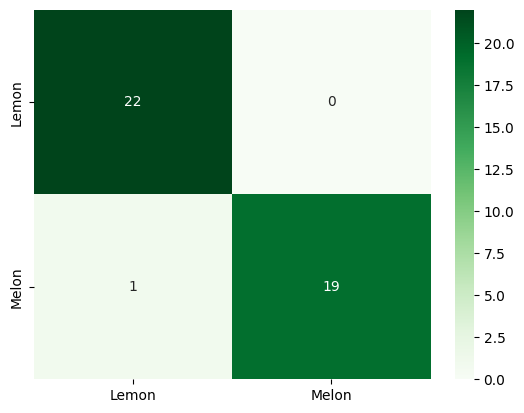

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, y_pred)
sns.heatmap(cm,cmap='Greens', annot=True, xticklabels = ["Lemon", "Melon"],yticklabels = ["Lemon", "Melon"])

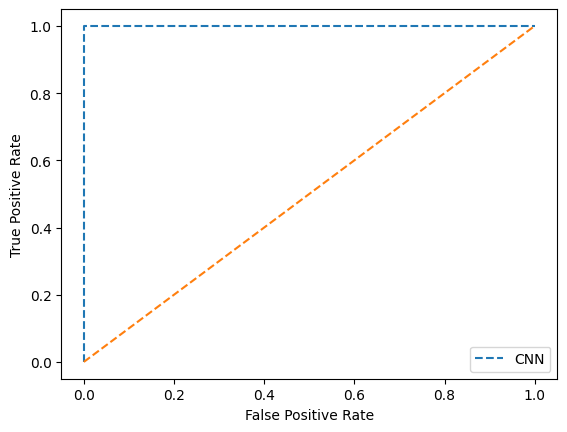

In [66]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

pred_prob = bm.predict(X)
pr1, tpr1, thresh1 = roc_curve(y, pred_prob, pos_label=1)


random_probs = [0 for i in range(len(y))]
p_fpr, p_tpr, _ = roc_curve(y, random_probs, pos_label=1)

plt.plot(pr1, tpr1, linestyle='--', label='CNN')
plt.plot(p_fpr, p_tpr, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [67]:
fl_experiment.remove_experiment_data()